# 0) RAG Chunking Demo: Naive vs Semantic Chunking

In [ ]:
# Uncomment if running in Colab or fresh environment
# !pip install PyMuPDF langchain nltk scikit-learn fpdf

In [1]:
import fitz  # PyMuPDF
import os
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from fpdf import FPDF
from matplotlib.patches import Rectangle
from sentence_transformers import SentenceTransformer


nltk.download('punkt')
from nltk.tokenize import sent_tokenize

C:\Users\wudyt\anaconda3\envs\demo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wudyt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Step 1: Generate a Sample PDF

In [4]:
def generate_sample_pdf(output_path):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    
    text = [
        "## Chapter 1 - Introduction",  # uses a simple "-"
        "The XYZ system is designed to optimize energy management.",
        "This chapter describes the main features and basic structure of the system.",
        "The XYZ system embodies years of research and passion from the ALFABETA family.",
        "A unique tradition of technological innovation encapsulated in the XYZ system",
        "",
        "## Chapter 2 - Installation",
        "To install the XYZ system, you must carefully follow the assembly instructions.",
        "Make sure all components are present and functioning before starting the installation.",
        "The control panel provides instructions on how to connect and start the system",
    ]

    for line in text:
        pdf.multi_cell(0, 10, line)
    pdf.output(output_path)

## Step 2: PDF Text Extraction and Chunking

In [7]:
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

def naive_chunking(text, chunk_size=500, overlap=50):
    chunks = []
    for i in range(0, len(text), chunk_size - overlap):
        chunks.append(text[i:i + chunk_size])
    return chunks

def semantic_chunking(text):
    pattern = r"(## .*?)(?=## |$)"
    matches = re.findall(pattern, text, flags=re.DOTALL)
    return [match.strip() for match in matches if match.strip()]

## Step 3: Visualization and Retrieval

In [10]:
def show_highlighted_chunks(text, chunks, title):
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.set_title(title)
    ax.set_xlim(0, len(text))
    ax.set_ylim(0, 1)
    for chunk in chunks:
        start = text.find(chunk)
        if start != -1:
            ax.add_patch(Rectangle((start, 0), len(chunk), 1, color='orange', alpha=0.4))
    ax.axis('off')
    plt.show()

def retrieve_best_chunk(query, chunks):
    vectorizer = TfidfVectorizer().fit(chunks + [query])
    vectors = vectorizer.transform(chunks + [query])
    sims = cosine_similarity(vectors[-1], vectors[:-1])[0]
    top_idx = int(np.argmax(sims))
    return chunks[top_idx], sims[top_idx]


def retrieve_best_chunk2(query, chunks):

    model = SentenceTransformer("all-MiniLM-L6-v2")
    # Chunks
    embeddings = model.encode(chunks, convert_to_numpy=True)      # shape: (n, 384)
    # Query sentence
    new_embedding = model.encode(query, convert_to_numpy=True)  # shape: (384,)
    sims = cosine_similarity(new_embedding.reshape(1, -1), embeddings)[0]  # shape: (n,)

    top_idx = int(np.argmax(sims))
    return chunks[top_idx], sims[top_idx]

## Step 4: Execute Pipeline

=== Naive Chunking ===
[Chunk 1]
## Chapter 1 - Introduction
The XYZ system is designed to optimize energy management.
This chapter describes the main features and basic structure of the system.
The XYZ system embodies years of research and passion from the ALFABETA family.
A unique tradition of technological innovation encapsulated in the XYZ system
## Chapter 2 - Installation
To install the XYZ system, you must carefully follow the assembly instructions.
Make sure all components are present and functioning before starting the

[Chunk 2]
ts are present and functioning before starting the installation.
The control panel provides instructions on how to connect and start the system


=== Semantic Chunking ===
[Chunk 1]
## Chapter 1 - Introduction
The XYZ system is designed to optimize energy management.
This chapter describes the main features and basic structure of the system.
The XYZ system embodies years of research and passion from the ALFABETA family.
A unique tradition of technolog

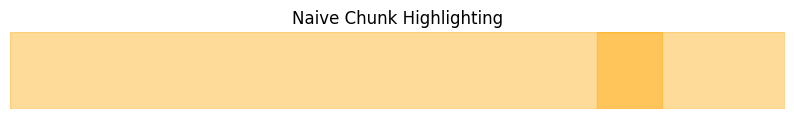

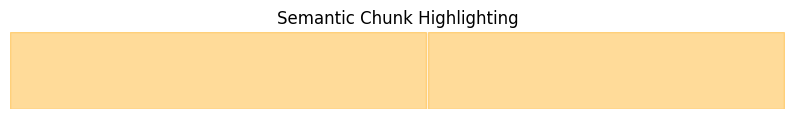

In [13]:
pdf_path = "sample_manual.pdf"
generate_sample_pdf(pdf_path)
text = extract_text_from_pdf(pdf_path)

naive_chunks = naive_chunking(text)
semantic_chunks = semantic_chunking(text)

print("=== Naive Chunking ===")
for i, chunk in enumerate(naive_chunks):
    print(f"[Chunk {i+1}]\n{chunk}\n")

print("=== Semantic Chunking ===")
for i, chunk in enumerate(semantic_chunks):
    print(f"[Chunk {i+1}]\n{chunk}\n")

query = "How do you install the XYZ system?"
naive_result, naive_score = retrieve_best_chunk2(query, naive_chunks)
semantic_result, semantic_score = retrieve_best_chunk2(query, semantic_chunks)

print("\n=== Retrieval Results ===")
print("Naive:", naive_result, f"[score={naive_score:.2f}]")
print("Semantic:", semantic_result, f"[score={semantic_score:.2f}]")

show_highlighted_chunks(text, naive_chunks, "Naive Chunk Highlighting")
show_highlighted_chunks(text, semantic_chunks, "Semantic Chunk Highlighting")